<a href="https://colab.research.google.com/github/JhngJng/Summer_Internship_2021/blob/main/Reading%20DeepWalk/DeepWalk_simple_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepWalk Simple Implementations

### Data Science & Artificial Intelligence Lab 2021 Summer Internship

#### Jihyeong Jung, Department of Mathematical Sciences, KAIST

In [19]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/Implementations_2021 Summer Internship/GCN'

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(root)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [20]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec

In [21]:
%matplotlib inline

def GraphGeneration(num_iter=50):
  '''
  `num_iter` : if it gets bigger, the graph's connection b/w groups gets stronger
  '''
  # Graph Initialization; by some 'primitive' way and using NetworkX library
  vertices1 = np.arange(0, 30, 1) # vertices as integers
  vertices2 = np.arange(30, 60, 1)
  vertices3 = np.arange(60, 90, 1)

  # generate edges
  rng = np.random.default_rng(42) # random generator random.choice
  unnormdist = np.array([1,1,1,1,1,2,2,2,2,3, 3,5,8,10,8,5,3,3,2,2, 2,2,1,1,1,1,2,3,4,5])
  dist = unnormdist/np.sum(unnormdist)
  num_iterate = num_iter
  edges = []

  for _ in range(num_iterate):
    edge1 = rng.choice(vertices1, 2, p=dist, replace=False).tolist()
    edge2 = rng.choice(vertices2, 2, p=dist, replace=False).tolist()
    edge3 = rng.choice(vertices3, 2, p=dist, replace=False).tolist()
    edges.append(edge1)
    edges.append(edge2)
    edges.append(edge3)

  # arr = np.arange(0, 50, 1)
  # rng.shuffle(arr)
  # connect = np.concatenate((vertices.reshape(-1,1), arr.reshape(-1,1)), axis=1).tolist()

  # for edge in connect[1:25]:
  #   edges.append(edge)

  for edge in edges:
    if edge[0]==edge[1]:
      edges.remove(edge)
    for edgee in edges:
      if (edge[0]==edgee[1]) and (edge[1]==edgee[0]):
        edges.remove(edgee)

  edges.append([1, 31])
  edges.append([1, 40])
  edges.append([52, 74])
  edges.append([52, 34])
  edges.append([31, 3])

  # print(edges, len(edges))

  arr = np.array(edges)
  edges = np.unique(arr, axis=0) # edges into numpy ndarray
  # print(edges, edges.shape)

  # set classes to vertices
  c0, c1, c2 = np.zeros(30), np.ones(30), np.ones(30)*2
  label = np.concatenate((np.concatenate((c0,c1)),c2)).reshape(-1,1)

  pd_edges = pd.DataFrame(edges, columns=['Go', 'To']) # edges to pandas DataFrame
  # print(pd_edges)

  # Construct Graph
  my_Graph = nx.from_pandas_edgelist(pd_edges, 'Go', 'To') # Construction

  return my_Graph

In [22]:
# Visualize Graph
def graph_plot(my_Graph):
  plt.figure(figsize=(20,15))
  nx.draw_networkx(G=my_Graph, node_color='blue', width=1.0, edge_color='skyblue', font_color='white')
  plt.show()

In [23]:
#### DeepWalk Algorithm ####
# reference : https://velog.io/@tyhlife/DeepWalk

def DeepWalk(G=None, w=10, d=2, gamma=30, t=40):
  '''
  <Input>
  Graph G (class networkx.Graph)

  <Hyperparameters>
  Window size w (int)
  Imbedding dimension d (int)
  Walks per vertex gamma (int)
  Walk length t (int)

  <Output>
  Imbedding X_embed (class numpy.ndarray)
  '''

  ############ defining function of making Random Walks #################
  def RandWalk(G, N, t):
    '''
    <Input>
    Graph G (class networkx.Graph)
    root node N
    Walk length t (int)

    <Output>
    Walk walk (python list)
    '''
    rng = np.random.default_rng(42)

    walk = [str(N)] # defining walk
    curr = N # current state

    # Sampling the nodes t-1 times
    for i in range(t-1):
      nbhd =  list(G.neighbors(curr)) # get list of neighbors of the current node
      # if given current node is isolated, break the loop.
      if len(nbhd) < 0:
        break

      next = rng.choice(nbhd) # next state
      curr = next # updating current state

      # recording
      walk.append(str(next))

    return walk
  ######################################################################
  rng = np.random.default_rng(42)
  NodeList = list(G.nodes())

  # Random Walk generating process
  walks = []
  for i in range(gamma):
    for node in NodeList:
      walk = RandWalk(G, node, t)
      walks.append(walk)
    rng.shuffle(NodeList) # shuffle the nodes

  # updating representation
  model = Word2Vec(sentences=walks, size=d, window=w, min_count=0, sg=1, hs=1, iter=100, batch_words=1)

  return model.wv.vectors, model

In [24]:
def representation_create_and_plot(my_Graph):
  import time
  ## creating representations of my_Graphs.
  t = time.time()
  ver_rep, model = DeepWalk(G=my_Graph, d=3)
  print(ver_rep)

  # plot the overall results
  fig = plt.figure(figsize=(32,18))
  ax = fig.gca(projection='3d')
  x, y, z = ver_rep[:,0], ver_rep[:,1], ver_rep[:,2]
  ax.scatter(x,y,z, s=150, c='blue')
  for i in range(30):
    if i in list(my_Graph.nodes()):
      vec = model.wv[str(i)]
      x, y, z = vec[0], vec[1], vec[2]
      ax.scatter(x,y,z, s=500, c='red')
  plt.title('representations for the graph <my_Graph>'.format, fontsize=24)
  plt.show()
  print("Elapsed time: {:.4f}s".format(time.time()-t))

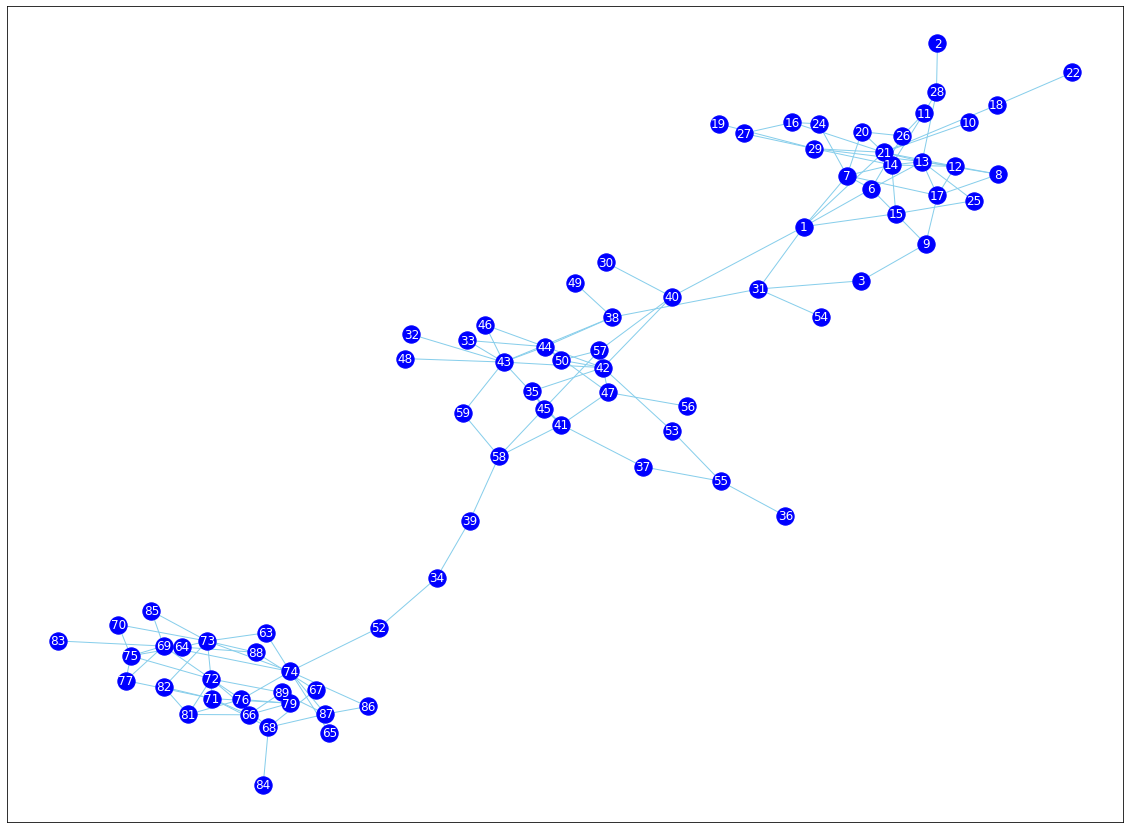

[[-1.9511437   0.4502762  -0.7166534 ]
 [ 1.3008294  -1.7211803  -3.4597192 ]
 [-1.6545264   0.82256657 -0.89038676]
 [ 1.2702988  -1.9351392  -3.4319513 ]
 [ 1.1807775  -1.735686   -3.2399664 ]
 [ 1.252688   -1.8072256  -3.343146  ]
 [-1.5614339   0.71515036 -0.8757435 ]
 [-1.7529887   0.615552   -0.79115695]
 [-1.9299563   0.43130645 -0.7049283 ]
 [-1.5764673   0.8921354  -1.0710918 ]
 [-1.7598536   1.1583474  -1.2213919 ]
 [-1.8869492   0.8926365  -0.9709803 ]
 [ 1.23656    -1.6672114  -3.324154  ]
 [ 1.2283074  -1.653316   -3.2778938 ]
 [-1.5016745   0.7163458  -0.9440343 ]
 [-1.2475026   0.93809247 -1.2999868 ]
 [ 1.2701107  -1.4627029  -3.3814712 ]
 [-1.4494591  -0.60684824 -0.25544277]
 [-1.8239241   0.09685322 -0.53458947]
 [-1.4768425   0.73063827 -0.91082275]
 [-1.7940027  -0.91143507 -0.17415   ]
 [-1.4954789   0.05228228 -0.5414193 ]
 [-1.3085171   0.8507802  -1.21688   ]
 [ 1.069368   -1.6858774  -2.960254  ]
 [ 1.178017   -1.6257714  -3.195652  ]
 [-1.03333     0.49972168

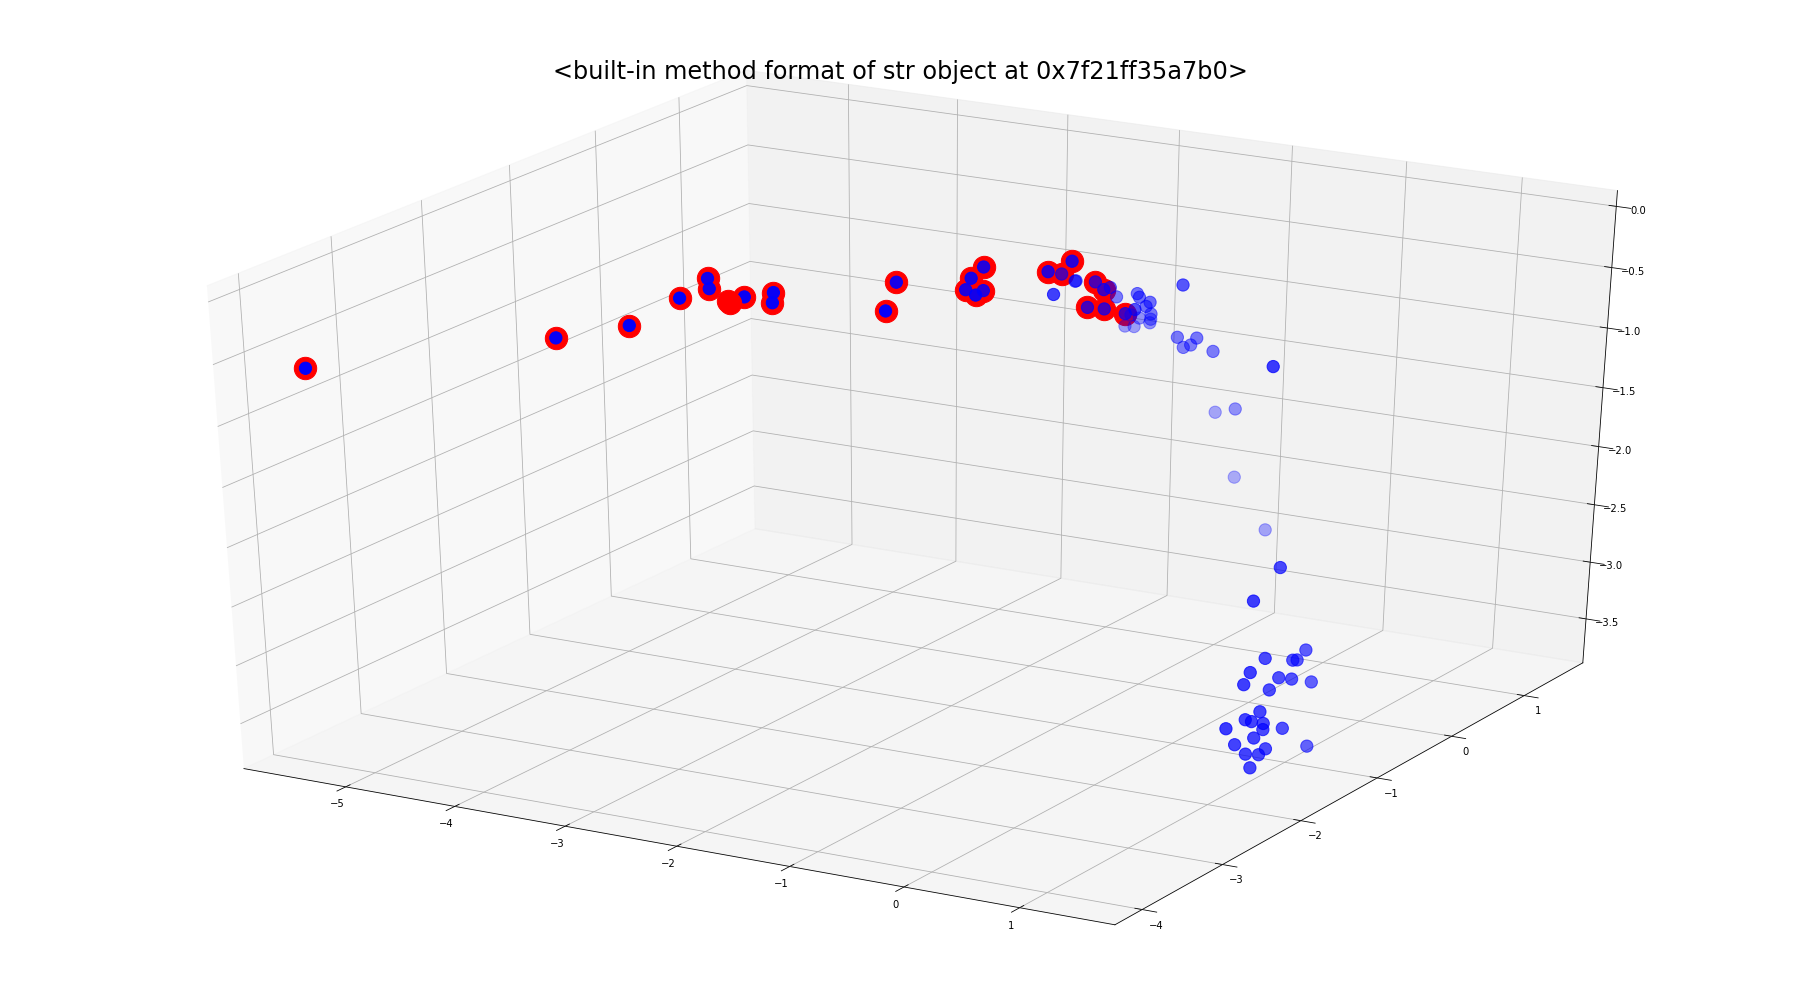

Elapsed time: 55.5486s


In [25]:
#### showing results of the random graphs by 'strength' of connections

# 1. weak group connection graph
graph50 = GraphGeneration(50)
graph_plot(graph50)
representation_create_and_plot(graph50)

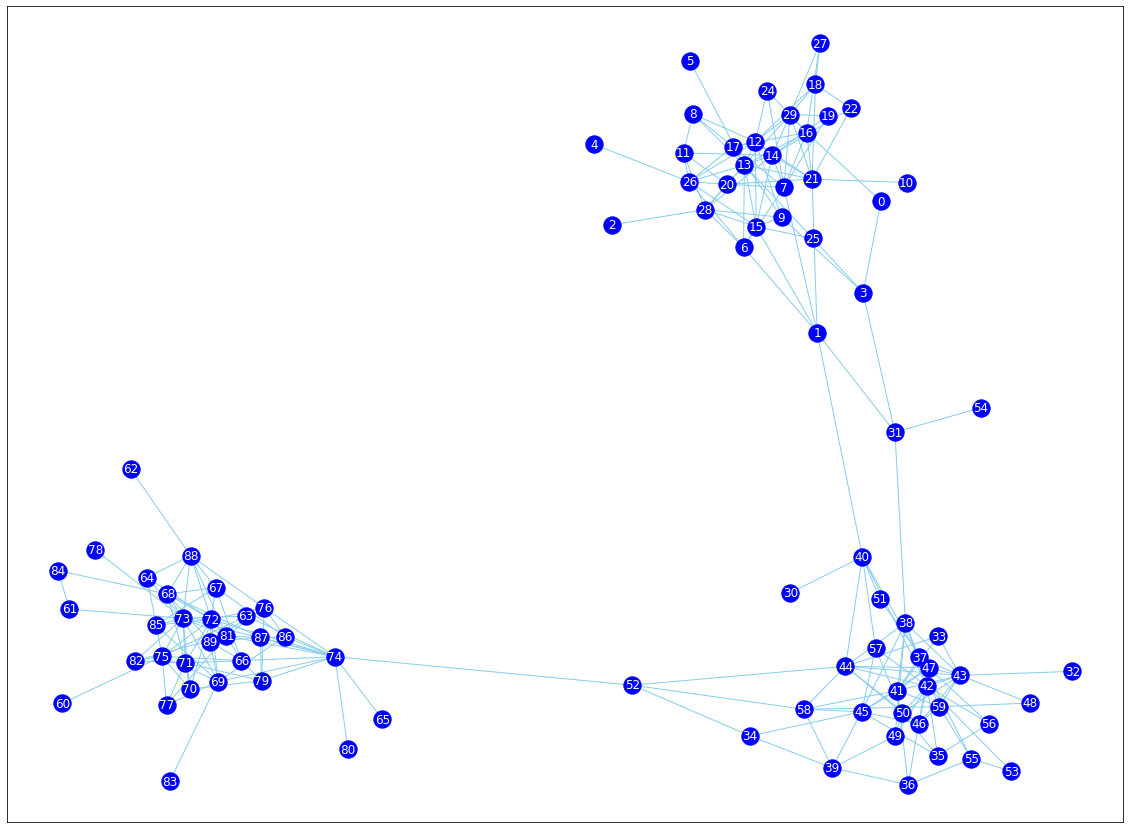

[[-2.712398    2.335239    1.183313  ]
 [-3.0467575   2.6309462   1.195918  ]
 [ 0.85643893  2.4983985  -1.3223525 ]
 [ 1.3686093   1.1140441   1.9275119 ]
 [ 1.5862343   1.2396592   1.9504104 ]
 [ 0.8420657   1.9827281  -0.95008373]
 [ 1.99146     1.4787368   2.068719  ]
 [-3.4298403   2.934376    1.4203873 ]
 [ 0.93340987  2.3475885  -1.1746933 ]
 [ 1.0792297   2.119703   -0.93414927]
 [-2.7466886   2.35925     1.2692056 ]
 [-2.9507906   2.5331824   1.2096025 ]
 [ 1.4812775   1.1803317   2.0273266 ]
 [ 0.999044    2.8957534  -1.5482448 ]
 [-3.1257253   2.6616497   1.4005344 ]
 [-2.9786313   2.5838113   1.1908542 ]
 [-2.903053    2.4836066   1.2855272 ]
 [ 1.5652231   1.2296908   2.0896287 ]
 [ 1.5121804   1.1268886   0.98004174]
 [ 0.9401195   3.4129524  -1.9064368 ]
 [-2.9851735   2.549173    1.3239241 ]
 [ 1.9494431   1.494931    2.427282  ]
 [-3.4693387   2.9506261   1.4579201 ]
 [ 0.87067705  2.5383065  -1.3146473 ]
 [ 0.8679875   1.6918051  -0.7294626 ]
 [ 1.9165219   1.4106547 

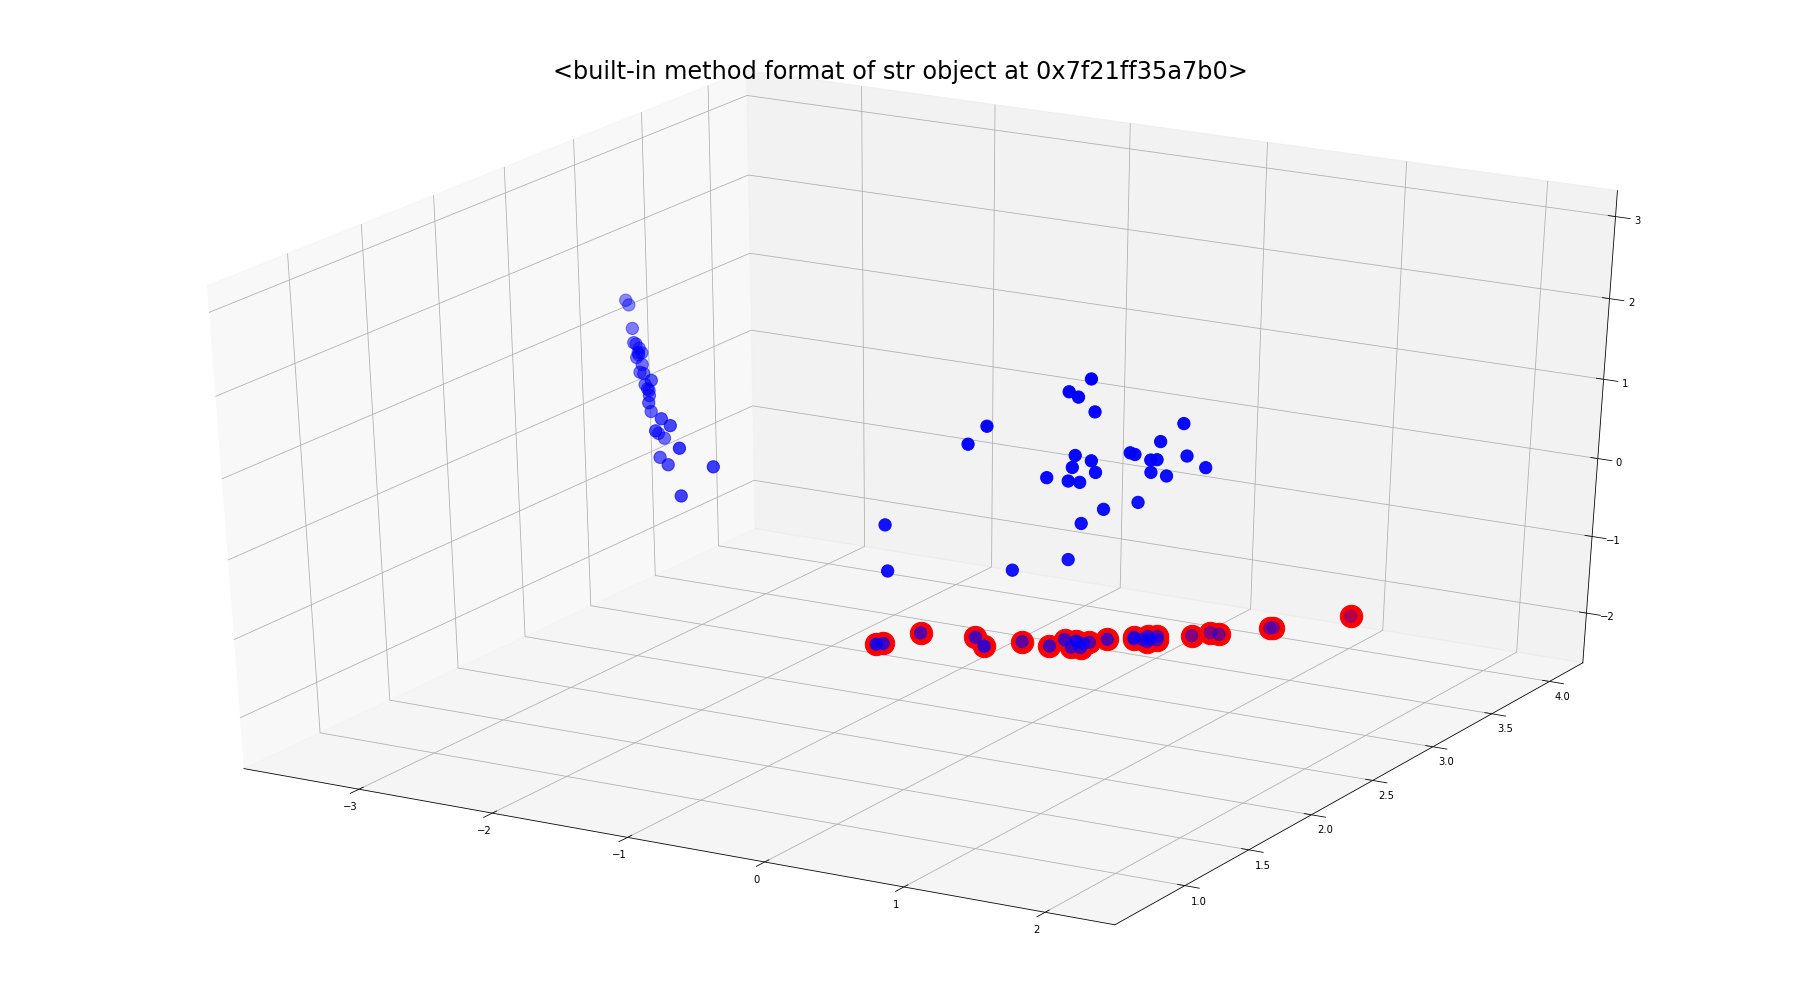

Elapsed time: 62.2820s


In [26]:
# 2. intermediate group connection graph
graph100 = GraphGeneration(100)
graph_plot(graph100)
representation_create_and_plot(graph100)

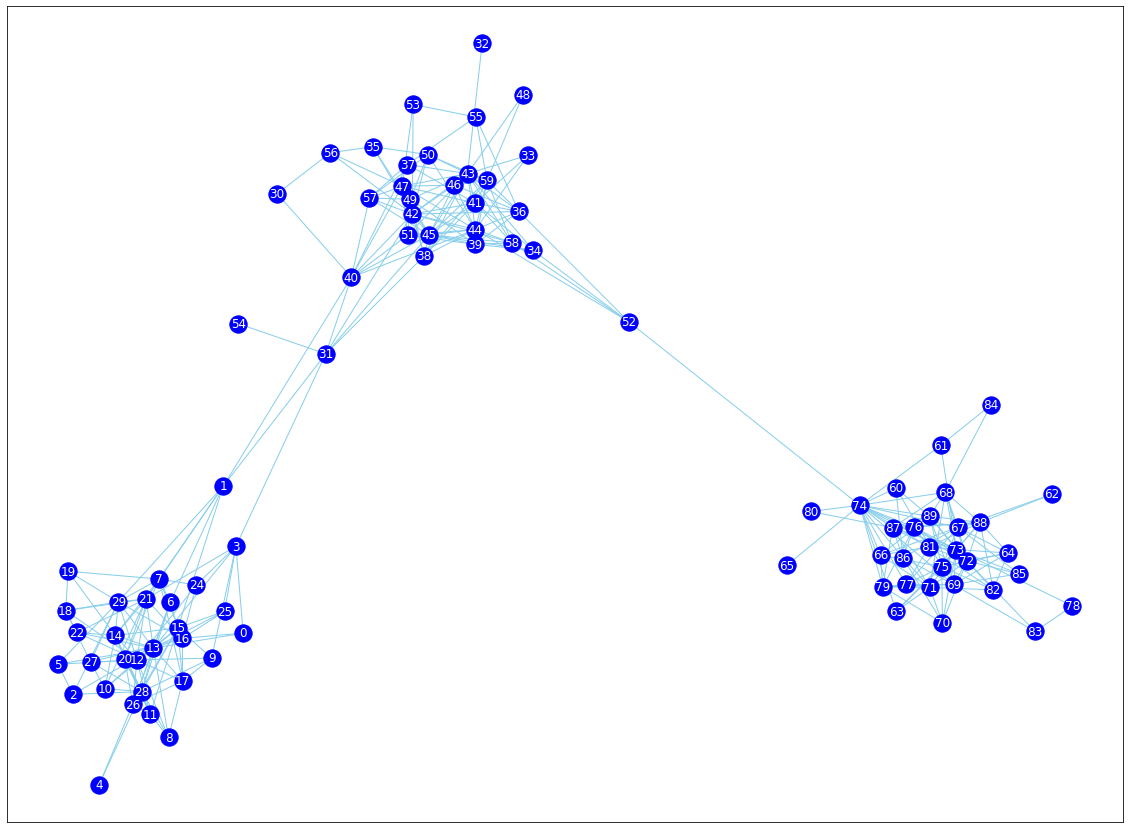

[[-0.12900104 -1.2147088   2.088665  ]
 [ 0.34024423 -1.4801881   2.1344326 ]
 [-0.0886531  -1.1808296   2.027617  ]
 [ 2.9897423   1.6185439   0.8615241 ]
 [-0.9166816   2.3580174   2.2348948 ]
 [ 2.7839649   1.518263    0.8305578 ]
 [ 3.487419    1.7287616   0.9685181 ]
 [ 3.361725    1.7005095   0.9341099 ]
 [ 0.31162596 -1.431515    2.1111302 ]
 [ 0.19004154 -1.326227    1.983299  ]
 [ 2.7686102   1.4946102   0.8060045 ]
 [-0.8640533   1.9266808   1.9417325 ]
 [ 2.9570253   1.5221186   0.8505241 ]
 [-0.8993264   1.9876899   2.011514  ]
 [-0.8129873   1.7752413   1.8069389 ]
 [-0.8463903   1.6594977   1.8037727 ]
 [ 3.0659776   1.5772116   0.87614465]
 [ 0.2146106  -1.3867338   2.0568907 ]
 [-0.863159    1.872665    1.9262613 ]
 [ 2.6659567   1.5004733   0.79878175]
 [-0.87991154  1.8386333   1.9188093 ]
 [-0.8116925   1.8173832   1.8435102 ]
 [ 3.0436451   1.4707829   0.8773887 ]
 [ 2.7979193   1.4875745   0.797769  ]
 [ 3.083457    1.6462977   0.87607056]
 [-0.12435146 -1.1736197 

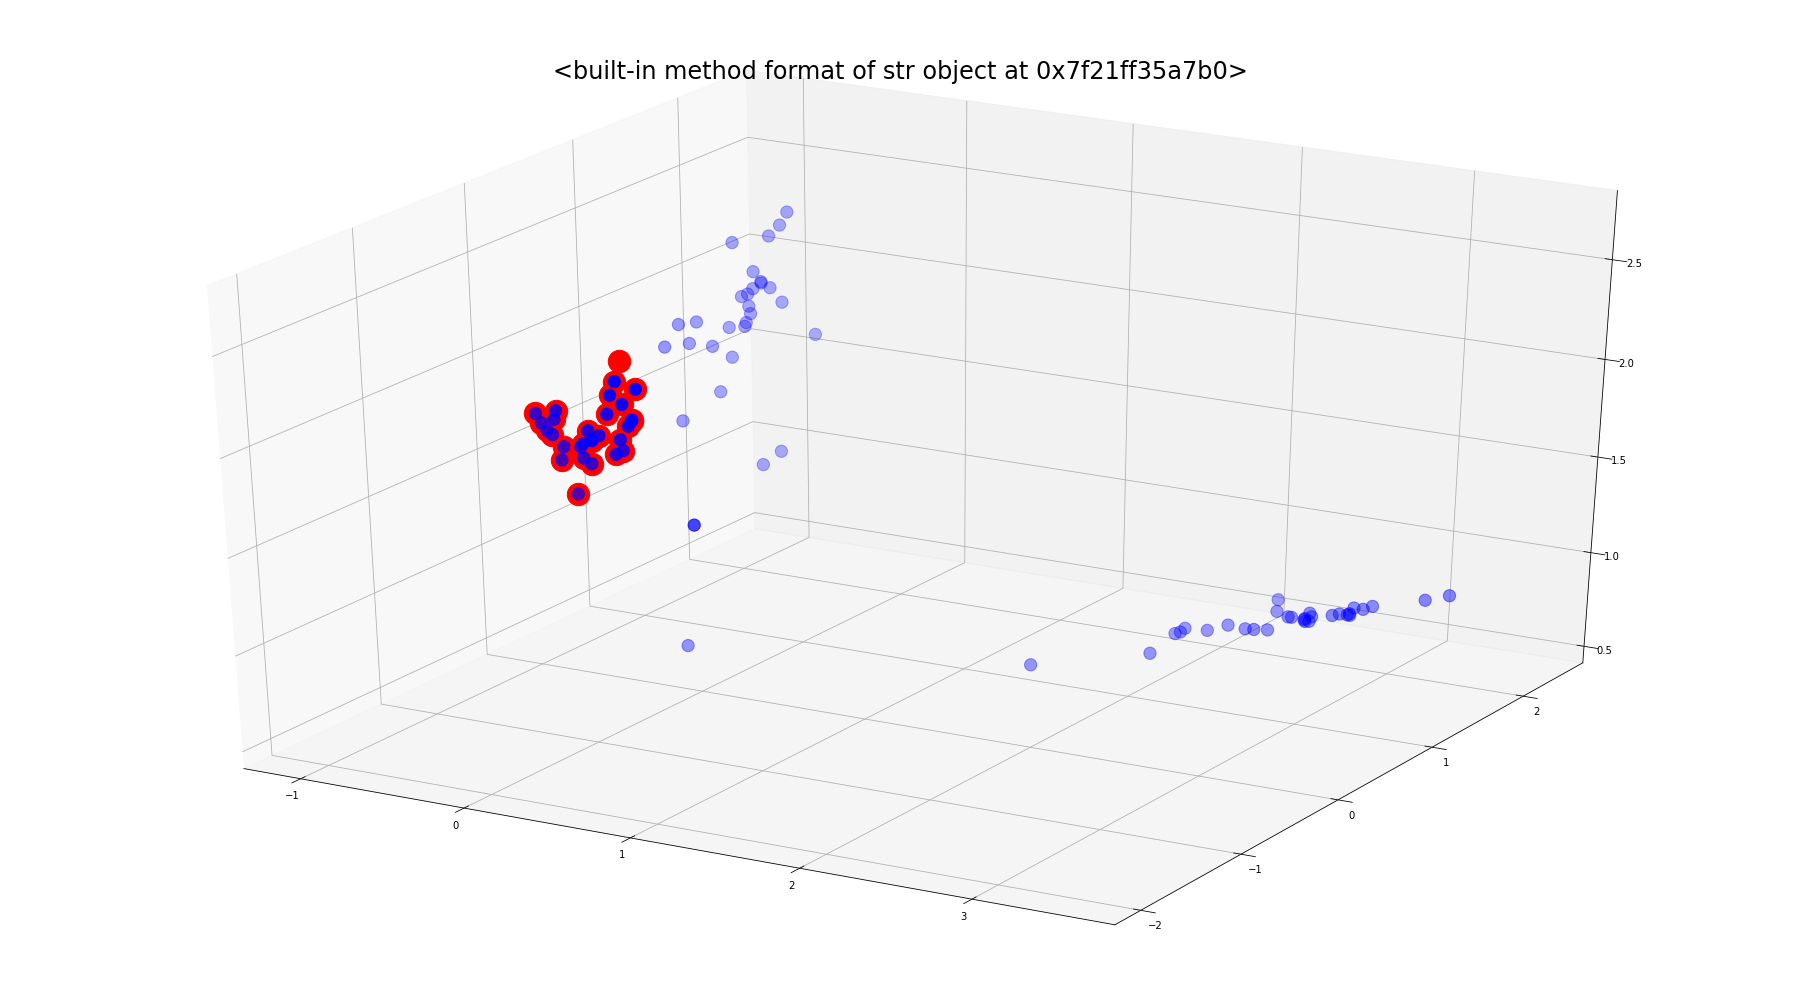

Elapsed time: 62.1540s


In [27]:
# 3. strong group connection graph
graph150 = GraphGeneration(150)
graph_plot(graph150)
representation_create_and_plot(graph150)